In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sms
%matplotlib inline

In [ ]:
df = pd.read_csv("airline_passengers.csv")
df.head()

,Month,Thousands of Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [ ]:
df.tail()

,Month,Thousands of Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    145 non-null    object 
 1   Thousands of Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
df.isnull().sum()

Month                      0
Thousands of Passengers    1
dtype: int64

In [ ]:
df[df['Thousands of Passengers'].isnull()]

,Month,Thousands of Passengers
144,International airline passengers: monthly tota...,NaN


In [ ]:
df = df.dropna(axis=0)
df.isnull().sum()

Month                      0
Thousands of Passengers    0
dtype: int64

In [ ]:
df.Month = pd.to_datetime(df['Month'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    144 non-null    datetime64[ns]
 1   Thousands of Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


<ipython-input-8-df27eadb5453>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Month = pd.to_datetime(df['Month'])


In [ ]:
df = df.set_index('Month')
df.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


<Axes: xlabel='Month'>

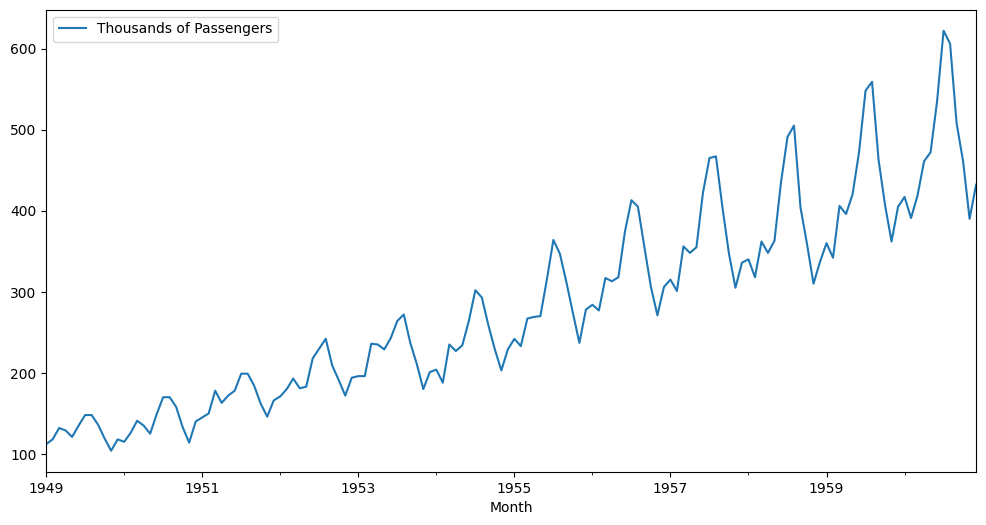

In [ ]:
df.plot(figsize=(12,6))

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def dickey_fuller(series):
  result = adfuller(series)
  print(f"ADF Statistics: {result[0]}")
  print(f"p-value: {result[1]}")
  if result[1] <= 0.05:
    print("Data is stationary!")
  else:
    print("Data is not stationary!")

In [ ]:
dickey_fuller(df['Thousands of Passengers'])

ADF Statistics: 0.8153688792060498
p-value: 0.991880243437641
Data is not stationary!


# Differencing

In [ ]:
df["First Difference"] = df['Thousands of Passengers'] - df['Thousands of Passengers'].shift(1)
df.head()

,Thousands of Passengers,First Difference
Month,,
1949-01-01,112.0,NaN
1949-02-01,118.0,6.0
1949-03-01,132.0,14.0
1949-04-01,129.0,-3.0
1949-05-01,121.0,-8.0


<Axes: xlabel='Month'>

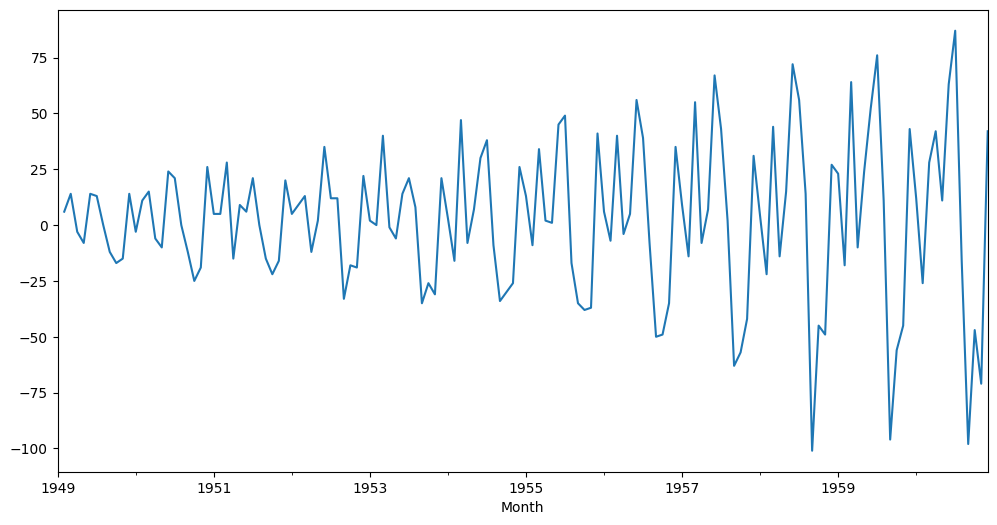

In [ ]:
df['First Difference'].plot(figsize=(12,6))

In [ ]:
dickey_fuller(df['First Difference'].dropna())

ADF Statistics: -2.8292668241700047
p-value: 0.05421329028382478
Data is not stationary!


In [ ]:
df["Second Difference"] = df['First Difference'] - df['First Difference'].shift(1)
df.head()

,Thousands of Passengers,First Difference,Second Difference
Month,,,
1949-01-01,112.0,NaN,NaN
1949-02-01,118.0,6.0,NaN
1949-03-01,132.0,14.0,8.0
1949-04-01,129.0,-3.0,-17.0
1949-05-01,121.0,-8.0,-5.0


<Axes: xlabel='Month'>

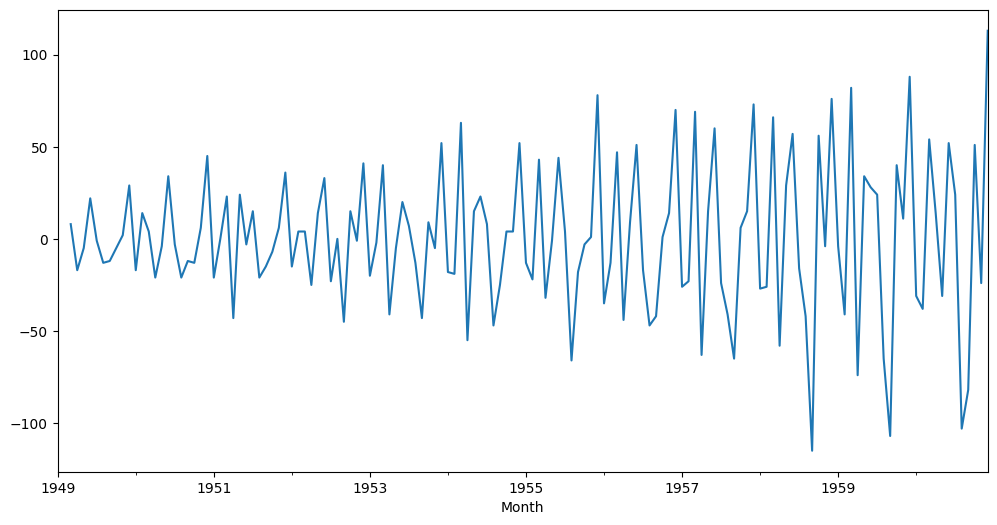

In [ ]:
df['Second Difference'].plot(figsize=(12,6))

In [ ]:
dickey_fuller(df['Second Difference'].dropna())

ADF Statistics: -16.384231542468513
p-value: 2.7328918500142026e-29
Data is stationary!


**Observation:**
We can clearly define d = 2

<Axes: xlabel='Month'>

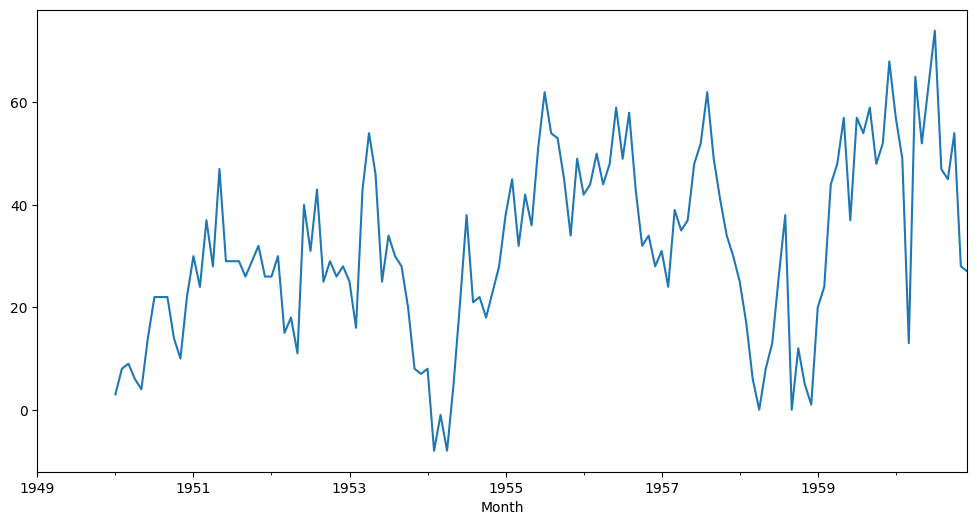

In [ ]:
# Since we know our data is seasonal on basis of 12 months
# We can also apply seasonal differencing
df["12th Difference"] = df['Thousands of Passengers'] - df['Thousands of Passengers'].shift(12)
df['12th Difference'].plot(figsize=(12,6))

In [ ]:
dickey_fuller(df['12th Difference'].dropna())

ADF Statistics: -3.383020726492481
p-value: 0.011551493085514952
Data is stationary!


# PACF and ACF

p value found using pacf and q value is determined using acf

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

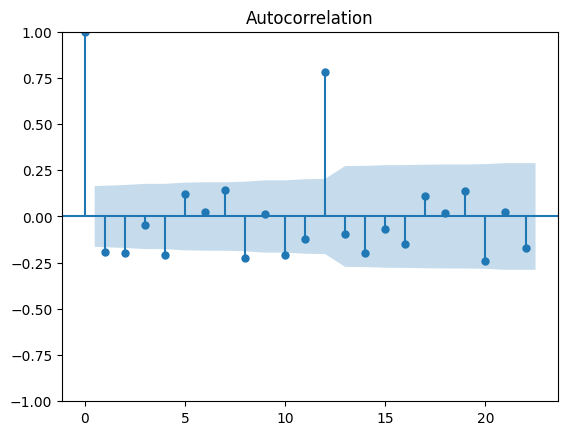

In [ ]:
acf = plot_acf(df['Second Difference'].dropna())

**Observation:**
We can see seasonality as at (t-0) and at (t-12) it is showing correlation

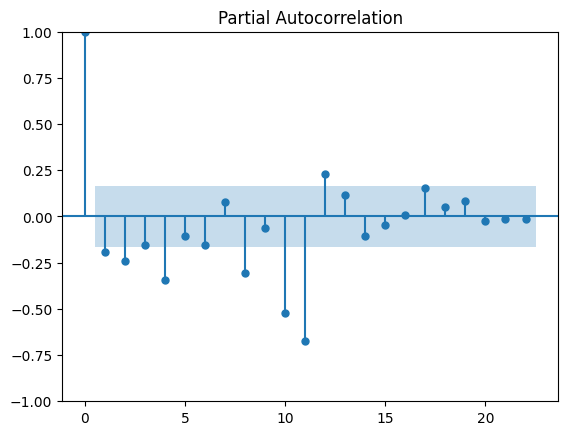

In [ ]:
pacf = plot_pacf(df['Second Difference'].dropna())

**Observation:**
We can notice same seasonality of (t-0) and (t-12) that was present in acf has well


So we will take p = 10 and q = 0 (as taking 12 makes it seasonal)

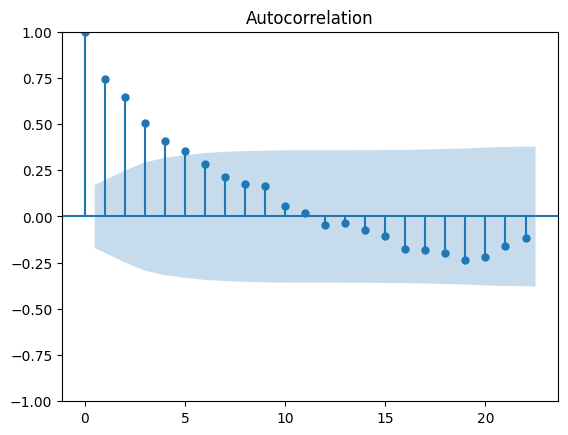

In [ ]:
acf12 = plot_acf(df['12th Difference'].dropna())

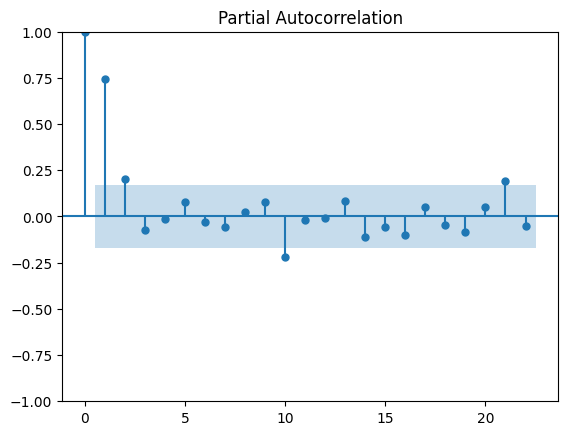

In [ ]:
pacf12 = plot_pacf(df['12th Difference'].dropna())

**Obervation:**
At 12th Differncing there is no seasonality present and we can clearly determine that p = 2 (or else p = 10) and q = 5

# Model

In [ ]:
from datetime import datetime, timedelta

In [ ]:
train_end = datetime(1955,12,1)
test_end = datetime(1960,12,1)

In [ ]:
train = df[:train_end]
test = df[train_end + timedelta(days=1):test_end]

In [ ]:
train.tail()

,Thousands of Passengers,First Difference,Second Difference,12th Difference
Month,,,,
1955-08-01,347.0,-17.0,-66.0,54.0
1955-09-01,312.0,-35.0,-18.0,53.0
1955-10-01,274.0,-38.0,-3.0,45.0
1955-11-01,237.0,-37.0,1.0,34.0
1955-12-01,278.0,41.0,78.0,49.0


In [ ]:
test.head()

,Thousands of Passengers,First Difference,Second Difference,12th Difference
Month,,,,
1956-01-01,284.0,6.0,-35.0,42.0
1956-02-01,277.0,-7.0,-13.0,44.0
1956-03-01,317.0,40.0,47.0,50.0
1956-04-01,313.0,-4.0,-44.0,44.0
1956-05-01,318.0,5.0,9.0,48.0


In [ ]:
# Prediction Range
pred_start = test.index[0]
pred_end = test.index[-1]
print(pred_start)
print(pred_end)

1956-01-01 00:00:00
1960-12-01 00:00:00


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
model = ARIMA(train['Thousands of Passengers'],order=(10,2,0))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
model_fit = model.fit()

In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Thousands of Passengers   No. Observations:                   84
Model:                     ARIMA(10, 2, 0)   Log Likelihood                -357.239
Date:                     Wed, 20 Mar 2024   AIC                            736.477
Time:                             17:53:23   BIC                            762.951
Sample:                         01-01-1949   HQIC                           747.106
                              - 12-01-1955                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5166      0.121     -4.262      0.000      -0.754      -0.279
ar.L2         -0.7204      0.121     -5.940      0.000      -0.958      -0.483
ar.L3         -0.4857      0.125     -3.876      0.000      -0.731      -0.240
ar.L4         -0.7505      0.129     -5.819      0.000      -1.003      -0.498
ar.L5         -0.5062      0.169     -2.991      0.003      -0.838      -0.175
ar.L6         -0.5200      0.141     -3.683      0.000      -0.797      -0.243
ar.L7         -0.3051      0.143     -2.127      0.033      -0.586      -0.024
ar.L8         -0.5939      0.155     -3.833      0.000      -0.898      -0.290
ar.L9         -0.2963      0.132     -2.241      0.025      -0.555      -0.037
ar.L10        -0.4825      0.110     -4.376      0.000      -0.699      -0.266
sigma2       336.0939     66.064      5.087      0.000     206.612     465.576
===================================================================================
Ljung-Box (L1) (Q):                  10.86   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.00   Prob(JB):                         0.54
Heteroskedasticity (H):               2.85   Skew:                             0.24
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred = model_fit.predict(start = pred_start, end = pred_end)
residual = test['Thousands of Passengers'] - pred

In [ ]:
residual.head()

Month
1956-01-01   -16.183612
1956-02-01   -32.478355
1956-03-01     0.556985
1956-04-01     5.172456
1956-05-01    -0.544234
dtype: float64

<Axes: ylabel='Density'>

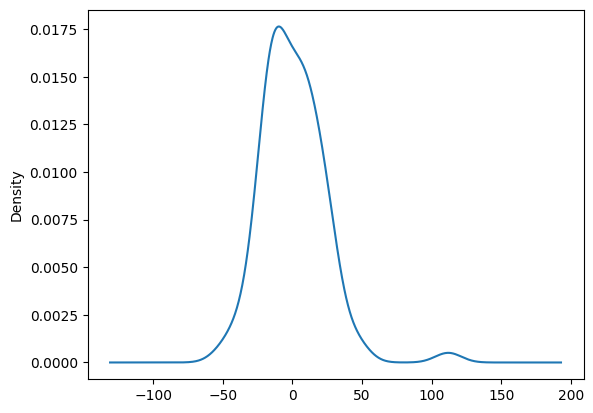

In [ ]:
model_fit.resid.plot(kind='kde')

In [ ]:
test["prediction_arima"] = pred
test.head()

<ipython-input-89-85f50b2eaa28>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction_arima"] = pred


,Thousands of Passengers,First Difference,Second Difference,12th Difference,prediction_arima
Month,,,,,
1956-01-01,284.0,6.0,-35.0,42.0,300.183612
1956-02-01,277.0,-7.0,-13.0,44.0,309.478355
1956-03-01,317.0,40.0,47.0,50.0,316.443015
1956-04-01,313.0,-4.0,-44.0,44.0,307.827544
1956-05-01,318.0,5.0,9.0,48.0,318.544234


<Axes: xlabel='Month'>

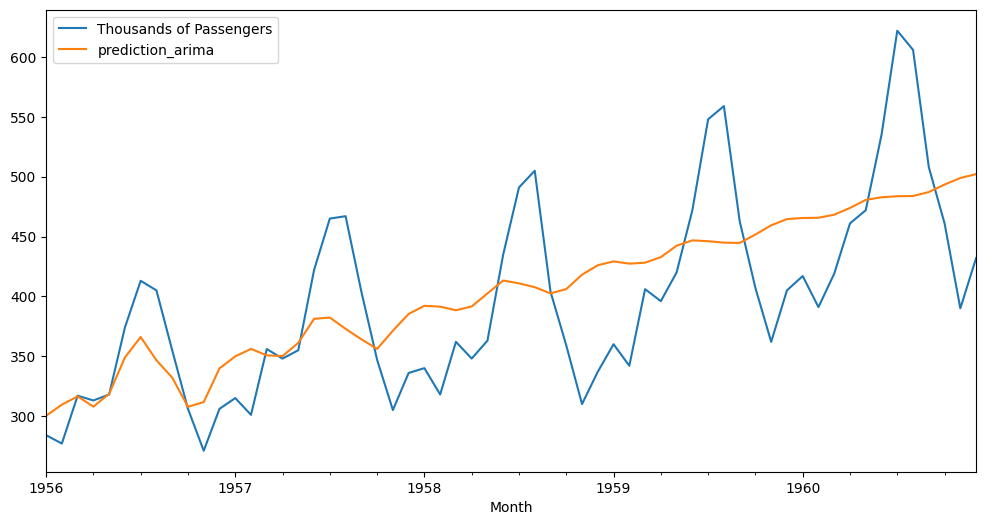

In [ ]:
test[["Thousands of Passengers","prediction_arima"]].plot(figsize = (12,6))

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
model_sarimax = SARIMAX(train['Thousands of Passengers'],order=(2,0,5),seasonal_order=(0,1,0,12))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
model_sarimax_fit = model_sarimax.fit()

In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Thousands of Passengers   No. Observations:                   84
Model:                     ARIMA(10, 2, 0)   Log Likelihood                -357.239
Date:                     Wed, 20 Mar 2024   AIC                            736.477
Time:                             18:06:56   BIC                            762.951
Sample:                         01-01-1949   HQIC                           747.106
                              - 12-01-1955                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5166      0.121     -4.262      0.000      -0.754      -0.279
ar.L2         -0.7204      0.121     -5.940      0.000      -0.958      -0.483
ar.L3         -0.4857      0.125     -3.876      0.000      -0.731      -0.240
ar.L4         -0.7505      0.129     -5.819      0.000      -1.003      -0.498
ar.L5         -0.5062      0.169     -2.991      0.003      -0.838      -0.175
ar.L6         -0.5200      0.141     -3.683      0.000      -0.797      -0.243
ar.L7         -0.3051      0.143     -2.127      0.033      -0.586      -0.024
ar.L8         -0.5939      0.155     -3.833      0.000      -0.898      -0.290
ar.L9         -0.2963      0.132     -2.241      0.025      -0.555      -0.037
ar.L10        -0.4825      0.110     -4.376      0.000      -0.699      -0.266
sigma2       336.0939     66.064      5.087      0.000     206.612     465.576
===================================================================================
Ljung-Box (L1) (Q):                  10.86   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.00   Prob(JB):                         0.54
Heteroskedasticity (H):               2.85   Skew:                             0.24
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred_sarimax = model_sarimax_fit.predict(start = pred_start, end = pred_end)
residual_sarimax = test['Thousands of Passengers'] - pred_sarimax

<Axes: ylabel='Density'>

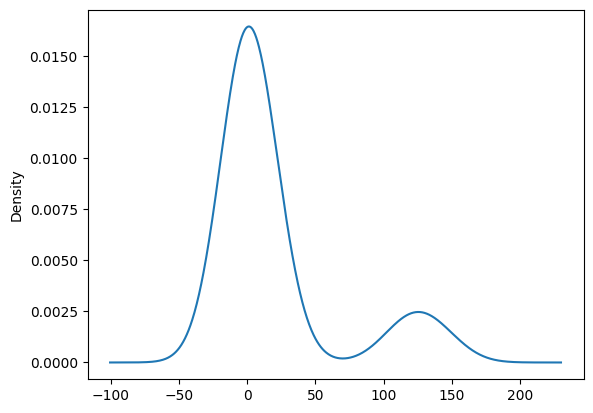

In [ ]:
model_sarimax_fit.resid.plot(kind='kde')

In [ ]:
test["prediction_sarimax"] = pred_sarimax
test.head()

<ipython-input-130-4c86230eacf5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction_sarimax"] = pred_sarimax


,Thousands of Passengers,First Difference,Second Difference,12th Difference,prediction_arima,prediction_sarimax
Month,,,,,,
1956-01-01,284.0,6.0,-35.0,42.0,300.183612,287.156049
1956-02-01,277.0,-7.0,-13.0,44.0,309.478355,281.418152
1956-03-01,317.0,40.0,47.0,50.0,316.443015,310.582627
1956-04-01,313.0,-4.0,-44.0,44.0,307.827544,310.746078
1956-05-01,318.0,5.0,9.0,48.0,318.544234,311.287558


<Axes: xlabel='Month'>

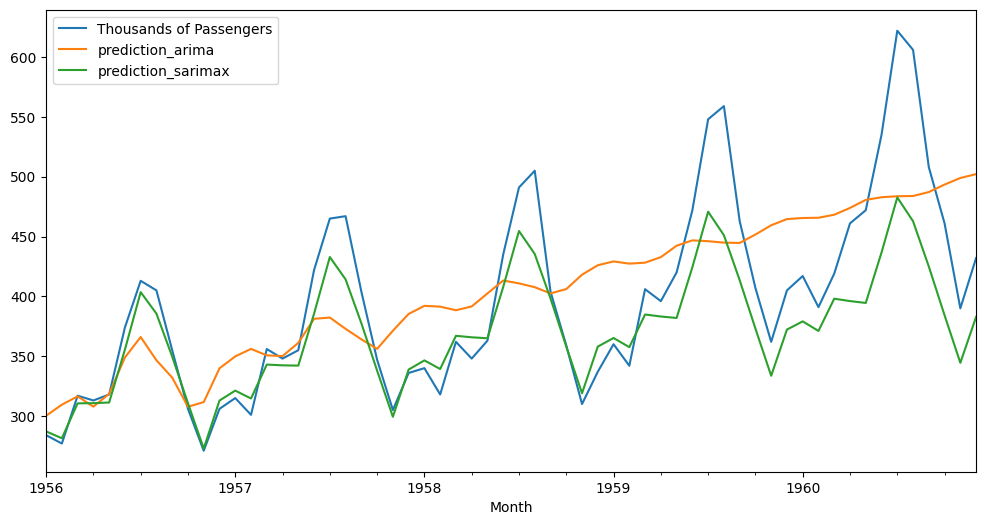

In [ ]:
test[["Thousands of Passengers","prediction_arima","prediction_sarimax"]].plot(figsize = (12,6))